# Machine Learning Engineer Nanodegree 

## Capstone Project
## Project: Building a Handwritten Digit Recognizer

## Introduction
In this project, we are going to build a Deep Neural Network(DNN) that can recognize the digit handwritten in an image. The DNN is trained over MNIST dataset containing handwritten digits and their respective numerical digit. There are many architecture in DNN. The architecture we are going to use in this project is Residual Neural Network (ResNet).

## Requirements
 - Python 2.7
 - Anaconda2
 - Keras
 - Tensorflow or Theano

## Data Exploration

Run the below code to import the required python libraries and initialize variables

In [42]:
from __future__ import print_function
from numpy import random
from keras.datasets import mnist # helps in loading the MNIST dataset
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from resnet import Residual
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#to plot inside the notebook itself
%matplotlib inline 

# to be able to reproduce the same randomness
random.seed(42)  

# No of rows and columns in the image
img_rows = 28
img_cols = 28

#No of output classes (0-9)
nb_classes = 10

### Load the Dataset
Keras provides api to download and load the mnist dataset in a single line. Run the below line to download and load the dataset as training and testing set. 

Training set has 60000 samples.
Testing set has 10000 samples.


Row pixels in each image : 28.
Column pixels in each image : 28.


Successfully Downloaded and Loaded the dataset


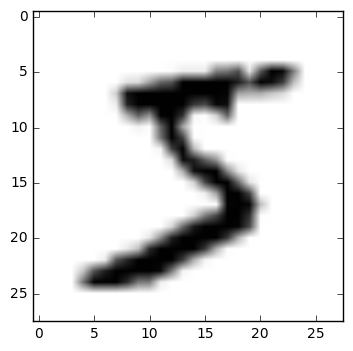

In [52]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Show the handwritten image
plt.imshow(X_train[0], cmap=cm.binary) 

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
print("\n")
# Show the number of rows and columns 
print("Row pixels in each image : {}.".format(X_train.shape[1]))
print("Column pixels in each image : {}.".format(X_train.shape[2]))
print("\n")
print("Successfully Downloaded and Loaded the dataset")

### Preprocess the Data

Keras can use either tensorflow or theano. While they both represent image in different format. Theano uses the format (no. of color channels, no. of rows, no. of cols) and tensorflow uses (no. of rows, no. of cols, no. of color channels). Thus a wrapper is needed when switching backends. Run the below code to ensure that the image is in the correct ordering for the respective background. 

In [41]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print("The data is reshaped to the respective format!" , input_shape)
print(y_train)

The data is reshaped to the respective format! (28, 28, 1)
[5 0 4 ..., 5 6 8]


The MNIST dataset contains grayscale images where the color channel value varies from 0 to 255. In order to reduce the computational load and training difficulty, we will map the values from 0 - 255 to 0 - 1 by dividing each pixel values by 255. Run the below code to do this.

In [36]:
X_train = X_train.astype('float32') #converted to float so that it can hold floating values between 0-1
X_test = X_test.astype('float32') #converted to float so that it can hold floating values between 0-1
X_train /= 255
X_test /= 255

The target labels y_train,y_test are in the form of numerical integers(0-9), we need to convert them to binary form in order for the neural network to perform mapping from input to output correctly and efficiently. Run the below code to do this.

In [46]:
print("In integer form : ", y_train,y_test)

Y_train = np_utils.to_categorical(y_train, nb_classes) #converted to their binary forms
Y_test = np_utils.to_categorical(y_test, nb_classes) #converted to their binary forms

print("In Binary form : ", Y_train,Y_test)

In integer form :  [5 0 4 ..., 5 6 8] [7 2 1 ..., 4 5 6]
In Binary form :  [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]] [[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


## Building the Residual Neural Network (ResNet)

TODO